In [1]:
!nvidia-smi

Thu Jul 11 17:11:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060 ...    Off | 00000000:26:00.0  On |                  N/A |
| 39%   46C    P3              27W / 175W |    631MiB /  8192MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [24]:
!pip install tensorflow-io
!pip install 'tensorflow[and-cuda]'

In [1]:
# Importing required libraries

import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow import keras
import numpy as np
import os
import subprocess as sp

2024-07-11 18:34:46.296512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 18:34:46.315733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 18:34:46.315762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 18:34:46.328206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 18:34:46.855860: W tensorflow/compiler/tf

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-07-11 18:34:48.626303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 18:34:48.662320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 18:34:48.662575: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Fetch available GPU memory
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

print("Available Memory:",get_gpu_memory())

Available Memory: [7380]


In [4]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [5]:
#Dataset directory path
dataset_dir = './Dataset/'
positive_calls = dataset_dir + 'Parsed_Capuchinbird_Clips/'
negative_calls = dataset_dir + 'Parsed_Not_Capuchinbird_Clips/'

positive_test = positive_calls + 'XC3776-0.wav'
negative_test = negative_calls + 'afternoon-birds-song-in-forest-0.wav'

In [6]:
# Creating a dataset pipeline
pos_data = tf.data.Dataset.list_files(positive_calls + '*.wav')
neg_data = tf.data.Dataset.list_files(negative_calls + '*.wav')

# Adding labels to the data
positives = tf.data.Dataset.zip((pos_data, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos_data)))))
negatives = tf.data.Dataset.zip((neg_data, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg_data)))))

# Creating a joint dataset
dataset = positives.concatenate(negatives)

2024-07-11 18:34:56.817906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 18:34:56.818372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 18:34:56.818748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
print("Positive Example: ", positives.as_numpy_iterator().next())
print("Negative Example: ", negatives.as_numpy_iterator().next())

Positive Example:  (b'./Dataset/Parsed_Capuchinbird_Clips/XC388470-6.wav', 1.0)
Negative Example:  (b'./Dataset/Parsed_Not_Capuchinbird_Clips/crickets-chirping-crickets-sound-23.wav', 0.0)


In [50]:
# Function to load and resample audio files
@tf.function
def load_n_resample(file_path):
    rate_out = 16000
    file_contents = tf.io.read_file(file_path)
    audio, rate_in = tf.audio.decode_wav(file_contents, desired_channels=1)
    rate_in = tf.cast(rate_in, dtype=tf.int64)
    audio = tf.squeeze(audio, axis = -1)

    #Resample the data to 16k
    resampled_audio = tfio.audio.resample(audio, rate_in, rate_out)

    return resampled_audio


In [9]:
pos_audio = load_n_resample(positive_test)
neg_audio = load_n_resample(negative_test)

2024-07-11 18:35:03.628770: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


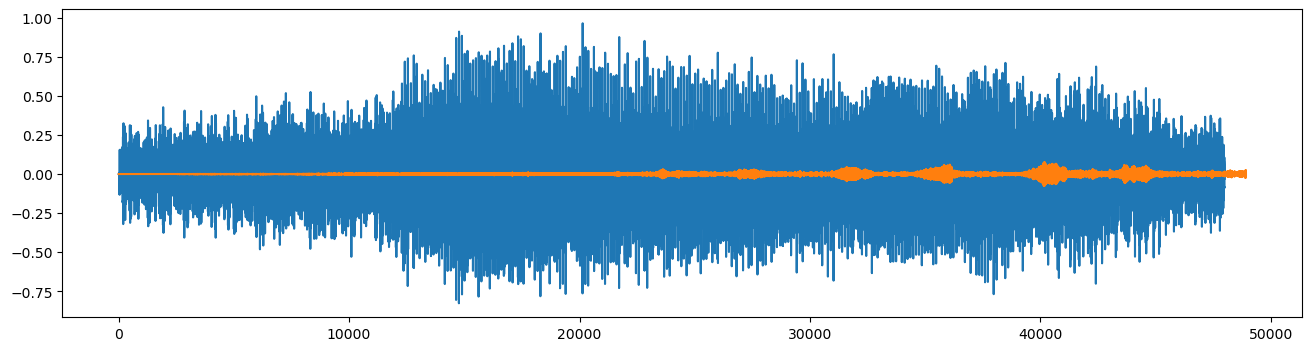

In [10]:
# Plot positive and negative bird call samples
plt.figure(figsize = (16,4))
plt.plot(pos_audio)
plt.plot(neg_audio)
plt.show()

In [13]:
# Average lenghth of each audio file in the dataset

length = []
for data in dataset.as_numpy_iterator():
    audio = load_n_resample(data[0])
    length.append(len(audio))

mean = tf.math.reduce_mean(length)
min = tf.math.reduce_min(length)
max = tf.math.reduce_max(length)

print('Mean: ', mean)
print('Max: ', max)
print('Min: ', min)

Mean:  tf.Tensor(50598, shape=(), dtype=int32)
Max:  tf.Tensor(80000, shape=(), dtype=int32)
Min:  tf.Tensor(32000, shape=(), dtype=int32)


2024-07-11 00:55:19.938907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Average audio clip length
print("Average clip length:",50598/16000)

Average clip length: 3.162375


In [12]:
# Trimming all the clip to 3s each and also generating the spectrogram
@tf.function
def preprocess(data, label):
    audio_file = load_n_resample(data)                                               # Loads the audio file
    audio_file = audio_file[:48000]                                                  # Select only first 3 secs of clip
    # padding = tf.zeros([48000] - tf.shape(audio_file), dtype = tf.float32)         # Zero padding for clips shorter than 3 secs
    # audio_file = tf.concat([padding, audio_file], 0)
    padding_length = 48000 - tf.shape(audio_file)[0]
    padding = tf.zeros([padding_length], dtype=tf.float32)  # Create padding
    audio_file = tf.concat([audio_file, padding], 0)

    spectrogram = tf.signal.stft(audio_file, frame_length = 320 , frame_step = 32)   # Generates spectrogram using short time fourier transform
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)                              # Expand to channel dimension for use with CNN

    spectrogram.set_shape([1491, 257, 1])                                            # Set the shape explicitly
    return spectrogram, label

In [13]:
data, label = dataset.shuffle(buffer_size=1000).as_numpy_iterator().next()
spec, label = preprocess(data, label)

print("Spectrogram: ", spec)
print("Label: ",label)

Spectrogram:  tf.Tensor(
[[[1.5371219e+00]
  [1.8707983e+00]
  [2.2858291e+00]
  ...
  [1.8110359e-04]
  [9.8251039e-05]
  [5.1617622e-05]]

 [[5.6377476e-01]
  [9.7896004e-01]
  [1.5650362e+00]
  ...
  [1.4117506e-04]
  [9.6707874e-05]
  [7.2300434e-05]]

 [[1.4103496e-01]
  [4.6096951e-01]
  [8.7877208e-01]
  ...
  [1.3366962e-04]
  [7.2977498e-05]
  [3.1016763e-05]]

 ...

 [[3.6056739e-01]
  [1.2634382e+00]
  [1.5777493e+00]
  ...
  [1.2373485e-04]
  [4.3098877e-05]
  [2.3499131e-05]]

 [[7.5926125e-01]
  [1.2172914e+00]
  [1.8577008e+00]
  ...
  [1.0728902e-04]
  [6.3909669e-05]
  [1.0728836e-06]]

 [[1.4055118e-01]
  [1.5156001e+00]
  [2.5421619e+00]
  ...
  [9.7298631e-05]
  [5.8810485e-05]
  [2.5965273e-05]]], shape=(1491, 257, 1), dtype=float32)
Label:  tf.Tensor(0.0, shape=(), dtype=float32)


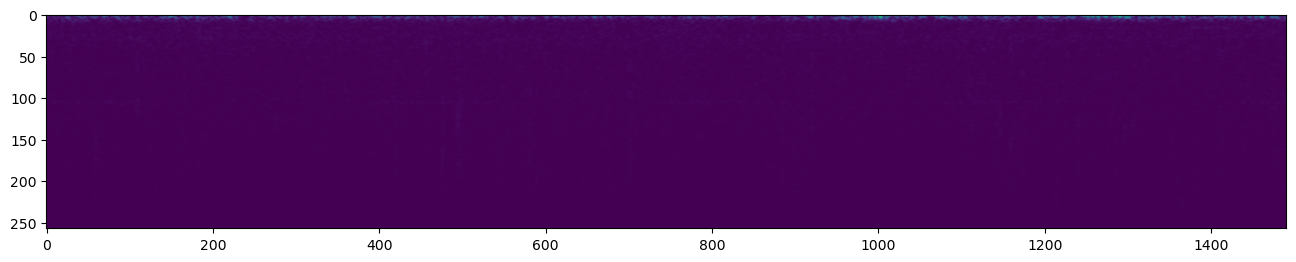

In [14]:
# Visualize the spectrogram
plt.figure(figsize=(16,4))
plt.imshow(tf.transpose(spec)[0])
plt.show()

In [15]:
# Finalizing the pipeline
dataset = dataset.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16, drop_remainder=True)
dataset = dataset.prefetch(8)

In [16]:
# Split data into test and train

total = len(dataset)
data_train = dataset.take(int(total*0.8))
data_test = dataset.skip(int(total*0.8)).take(total - int(total*0.8))

In [17]:
print("Total Samples:", total)
print("Training data size:", len(data_train))
print("Testing data size:", len(data_test))

Total Samples: 50
Training data size: 40
Testing data size: 10


In [18]:
# Confirm the shape of tensors in the dataset
dataset.element_spec

(TensorSpec(shape=(16, 1491, 257, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(16,), dtype=tf.float32, name=None))

In [20]:
# Build the neural network
model = Sequential()
model.add(keras.Input(shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation = 'relu'))
model.add(Conv2D(16, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
# Compile the model
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1487, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 743, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1497888)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    95,864,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,867,441 (365.71 MB)

 Trainable params: 95,867,441 (365.71 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Start Training with epoch set to 8
history = model.fit(data_train, epochs = 8, validation_data = data_test)

Epoch 1/8


I0000 00:00:1720703181.440581    8564 service.cc:145] XLA service 0x71c124bdda40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720703181.440630    8564 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-07-11 18:36:21.480192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 18:36:21.617157: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-07-11 18:36:28.333529: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng1{k2=2,k3=0} for conv (f32[16,16,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,16,1489,255]{3,2,1,0}, f32[16,16,1487,253]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operat

 2/40 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5000 - loss: 2.4251 

I0000 00:00:1720703190.782019    8564 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - accuracy: 0.8352 - loss: 2.2211 - val_accuracy: 0.9875 - val_loss: 0.1254
Epoch 2/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9958 - loss: 0.0427 - val_accuracy: 0.9875 - val_loss: 0.0659
Epoch 3/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9935 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 4/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9984 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9969 - loss: 0.0107 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 6/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 1.0000 - loss: 4.4538e-04 - val_accuracy: 1.0000 - val_loss: 1.9701e-04
Epoch 7/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9984 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 6.1325e-04
Epoch 8/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 1.0000 - loss: 3.4210e-04 - val_accuracy: 1.0000 

In [43]:
# Pick 1 batch from test set
sample = data_test.take(1)
data, label = sample.as_numpy_iterator().next()

In [49]:
# Validate the model output against the actual label
y_test = model.predict(data)
predictions = [1 if pred[0]>0.5 else 0 for pred in y_test]
print("Label:", label, "\nPrediction:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Label: [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.] 
Prediction: [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]


In [56]:
# Save the trained model
model.save('./Models/audio_classifier.keras')